# Wizard of Wikipedia

## Load data

In [4]:
import json
import os
from typing import Dict, List, Optional, Tuple

from tqdm import tqdm


def get_gold_passage(turn: dict) -> Tuple[Optional[str], Optional[str]]:
    if len(turn["checked_sentence"]) == 0:
        return None, None
    key, sentence = next(iter(turn["checked_sentence"].items()))
    if key == "no_passages_used":
        return None, None
    if len(turn["checked_passage"]) == 0:
        topic = " ".join(key.split("_")[1:-1])
    else:
        topic = next(iter(turn["checked_passage"].values()))

    return topic, sentence


def get_retrieved_passages(turn: dict) -> Dict[str, List[str]]:
    retrieved_passages = {}
    for passages_per_topic in turn["retrieved_passages"]:
        for topic, passages in passages_per_topic.items():
            retrieved_passages[topic] = passages

    return retrieved_passages


def get_self_and_partner_passages(
    passages: List[Dict[str, List[str]]]
) -> Tuple[Dict[str, List[str]], Dict[str, List[str]]]:

    if len(passages) == 0:
        self_passages, partner_passages = {}, {}
    elif len(passages) == 1:
        self_passages, partner_passages = {}, passages[-1]
    else:
        self_passages, partner_passages = passages[-2], passages[-1]

    return self_passages, partner_passages

In [5]:
def prepare_wizard_of_wikipedia(data_dir):

    splits = {}
    for split, filename in zip(
        ["train", "valid", "test"],
        ["train.json", "valid_topic_split.json", "test_topic_split.json"],
    ):
        with open(os.path.join(data_dir, filename), "r") as f:
            data = json.load(f)

        dataset = {}
        discarded_turns = {}
        for dialogue_id, dialogue in enumerate(
            tqdm(data, desc=f"Processing {split} dialogues")
        ):
            chosen_topic = dialogue["chosen_topic"]
            chosen_topic_passage = dialogue["chosen_topic_passage"]
            dialoue_history = [
                chosen_topic  # add the chosen topic as first turn like in the WoW paper
            ]
            passages = []
            for turn_id, turn in enumerate(dialogue["dialog"]):
                text = turn["text"]
                if turn["speaker"].endswith("Wizard"):
                    try:
                        gold_topic, sentence = get_gold_passage(turn)

                        self_passages, partner_passages = get_self_and_partner_passages(
                            passages
                        )

                        dataset[f"dial_{dialogue_id}_turn_{turn_id}"] = {
                            "dialogue_id": dialogue_id,
                            "turn_id": turn_id,
                            "speaker": "wizard",
                            "dialogue_history": dialoue_history.copy(),
                            "text": text,
                            "gold_sentence": {
                                "sentence": sentence,
                                "topic": gold_topic,
                            },
                            "chosen_topic": chosen_topic,
                            "chosen_topic_passage": chosen_topic_passage,
                            "partner_passages": partner_passages,
                            "self_passages": self_passages,
                        }

                    except ValueError as e:
                        discarded_turns[f"dial_{dialogue_id}_turn_{turn_id}"] = str(e)
                else:
                    dataset[f"dial_{dialogue_id}_turn_{turn_id}"] = {
                        "dialogue_id": dialogue_id,
                        "turn_id": turn_id,
                        "speaker": "apprentice",
                        "text": text,
                        "chosen_topic": chosen_topic,
                    }

                # append the passages for the current turn and use them for the next one
                passages.append(get_retrieved_passages(turn))
                # append the text to the dialogue history
                dialoue_history.append(text)

        total_turns = len(dataset)
        discarded_turns_count = len(discarded_turns)
        percentage_discarded_turns = (
            discarded_turns_count / (total_turns + discarded_turns_count)
        ) * 100
        print(f"Percentage of discarded turns: {percentage_discarded_turns}%")

        splits[split] = dataset
    
    return splits

In [6]:
splits = prepare_wizard_of_wikipedia("../original_data/WizardOfWikipedia")

Processing train dialogues: 100%|██████████| 18430/18430 [00:03<00:00, 5717.38it/s] 


Percentage of discarded turns: 0.0%


Processing valid dialogues: 100%|██████████| 967/967 [00:00<00:00, 13842.21it/s]


Percentage of discarded turns: 0.0%


Processing test dialogues: 100%|██████████| 968/968 [00:00<00:00, 15882.98it/s]

Percentage of discarded turns: 0.0%


## Stats

In [7]:
import numpy as np

def analyze_splits(splits):
    topics = {}
    for split, turns in splits.items():
        n_tokens_per_turn = []
        n_wizard_turns = 0
        n_tokens_per_dialogue = {}
        n_turns_with_no_passages = 0
        n_tokens_per_passage = []
        if split not in topics:
            topics[split] = set()
        for turn in turns.values():
            if turn["dialogue_id"] not in n_tokens_per_dialogue:
                n_tokens_per_dialogue[turn["dialogue_id"]] = 0
            n_tokens_per_turn.append(len(turn["text"].split()))
            n_tokens_per_dialogue[turn["dialogue_id"]] += len(turn["text"].split())
            topics[split].add(turn["chosen_topic"])
            if turn["speaker"] == "wizard":
                n_wizard_turns += 1
                if turn["gold_sentence"]["sentence"] is None:
                    n_turns_with_no_passages += 1
                else:
                    n_tokens_per_passage.append(len(turn["gold_sentence"]["sentence"].split()))

        
        print(split.upper())
        print(f"\t# DIALS: {len(n_tokens_per_dialogue)}")
        print(f"\t# UNIQUE TOPICS: {len(topics[split])}")
        print(f"\tAVG # TURNS PER DIAL: ", len(turns)/len(n_tokens_per_dialogue))
        print(f"\tAVG # TOKENS PER TURN: {np.mean(n_tokens_per_turn)}")
        print(f"\tAVG # TOKENS PER DIAL: {np.mean(list(n_tokens_per_dialogue.values()))}")
        print(f"\t% (WIZARD) TURNS WITH NO KNOWLEDGE: {n_turns_with_no_passages/n_wizard_turns*100}%")
        print(f"\tAVG # TOKENS PER (GOLD) SENTENCE: {np.mean(n_tokens_per_passage)}")
    
    return topics

In [8]:
topics = analyze_splits(splits)

TRAIN
	# DIALS: 18430
	# UNIQUE TOPICS: 1247
	AVG # TURNS PER DIAL:  9.049755832881171
	AVG # TOKENS PER TURN: 16.372738882526814
	AVG # TOKENS PER DIAL: 148.1692892023874
	% (WIZARD) TURNS WITH NO KNOWLEDGE: 6.87231972323327%
	AVG # TOKENS PER (GOLD) SENTENCE: 22.54549441477698
VALID
	# DIALS: 967
	# UNIQUE TOPICS: 54
	AVG # TURNS PER DIAL:  9.10651499482937
	AVG # TOKENS PER TURN: 16.410174880763115
	AVG # TOKENS PER DIAL: 149.43950361944158
	% (WIZARD) TURNS WITH NO KNOWLEDGE: 6.069561263923619%
	AVG # TOKENS PER (GOLD) SENTENCE: 21.78872216844143
TEST
	# DIALS: 968
	# UNIQUE TOPICS: 58
	AVG # TURNS PER DIAL:  9.072314049586776
	AVG # TOKENS PER TURN: 16.125939421544068
	AVG # TOKENS PER DIAL: 146.2995867768595
	% (WIZARD) TURNS WITH NO KNOWLEDGE: 5.821917808219178%
	AVG # TOKENS PER (GOLD) SENTENCE: 22.84048484848485


In [9]:
import math
from nltk.tokenize import sent_tokenize

n_wizard_turns = 0
system_tokens_per_turn = []
system_sentences_per_turn = []
for turn in list(splits["train"].values()) + list(splits["valid"].values()):
    if turn["speaker"] == "wizard":
        n_wizard_turns += 1
        system_tokens_per_turn.append(len(turn["text"].split()))
        system_sentences_per_turn.append(len(sent_tokenize(turn["text"])))


print(f"\tAVG # TOKENS PER SYSTEM TURN: {np.mean(system_tokens_per_turn)}")
print(f"\tSTD # TOKENS PER SYSTEM TURN: {np.std(system_tokens_per_turn)}")
print(f"\tAVG # SENTENCES PER SYSTEM TURN: {np.mean(system_sentences_per_turn)}")
print(f"\tSTD # SENTENCES PER SYSTEM TURN: {np.std(system_sentences_per_turn)}")
print()
print(f"97.7% of SYS sentence have no more than {math.ceil(np.mean(system_tokens_per_turn) + 2*np.std(system_tokens_per_turn))} tokens")
print(f"97.7% of SYS turns have no more than {math.ceil(np.mean(system_sentences_per_turn) + 2*np.std(system_sentences_per_turn))} sentences")

	AVG # TOKENS PER SYSTEM TURN: 18.431360244620404
	STD # TOKENS PER SYSTEM TURN: 7.8527370320803005
	AVG # SENTENCES PER SYSTEM TURN: 1.6476393674554457
	STD # SENTENCES PER SYSTEM TURN: 0.7870277710048533

97.7% of SYS sentence have no more than 35 tokens
97.7% of SYS turns have no more than 4 sentences


In [10]:
def check_topic_splits(topics):
    for split, split_topics in topics.items():
        for other_split, other_split_topics in topics.items():
            if split != other_split:
                if len(split_topics.intersection(other_split_topics)) > 0:
                    print(f"Split {split} has topics that are also in split {other_split}")
                    return False
    return True

topic_splits_valid = check_topic_splits(topics)
print(f"No topic is inside another split: {topic_splits_valid}")


No topic is inside another split: True


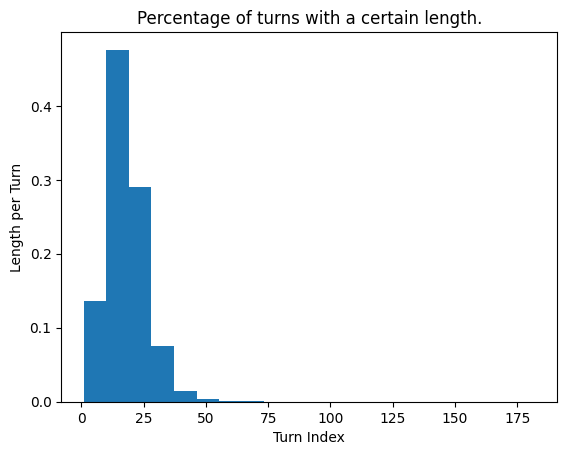

Number of turns 87646


In [11]:
import matplotlib.pyplot as plt

# Calculate the length per turn
lengths = []
for split in ["train", "valid"]:
    data = splits[split].values()
    for turn in data:
        if turn["speaker"] == "wizard":
            lengths.append(len(turn["text"].split()))

# Create the bar plot
y, bins, fig = plt.hist(lengths, 20, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("Turn Index")
plt.ylabel("Length per Turn")
plt.title("Percentage of turns with a certain length.")
plt.show()
print(f"Number of turns {len(lengths)}")


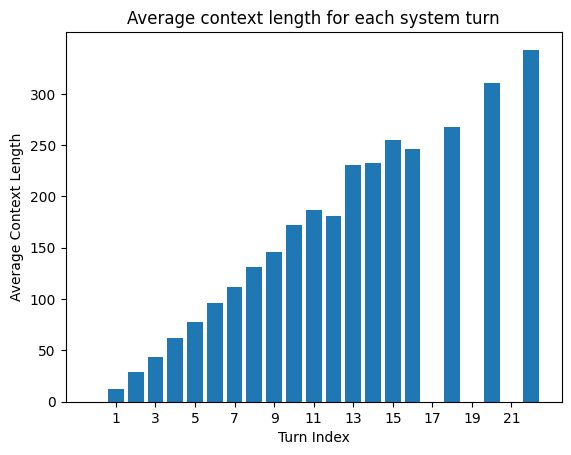

In [12]:
cumulative_lenghts_per_turn = {}

for split in ["train", "valid"]:
    context_length = {}
    for sample_id, turn in splits[split].items():
        turn_id = int(sample_id.split("_")[-1])
        dialog_id = int(sample_id.split("_")[1])
        if dialog_id not in context_length:
            context_length[dialog_id] = 0
        if turn["speaker"] == "wizard":
            if turn_id not in cumulative_lenghts_per_turn:
                cumulative_lenghts_per_turn[turn_id] = []
            cumulative_lenghts_per_turn[turn_id].append(context_length[dialog_id])
        context_length[dialog_id] += len(turn["text"].split())

cumulative_lenghts_per_turn = {k: np.mean(v) for k, v in cumulative_lenghts_per_turn.items()}
plt.bar(cumulative_lenghts_per_turn.keys(), cumulative_lenghts_per_turn.values())
plt.yticks(np.arange(0, max(cumulative_lenghts_per_turn.values())+1, 50))
plt.xticks(np.arange(1, max(cumulative_lenghts_per_turn)+1, 2))
plt.xlabel("Turn Index")
plt.ylabel("Average Context Length")
plt.title("Average context length for each system turn")
plt.show()

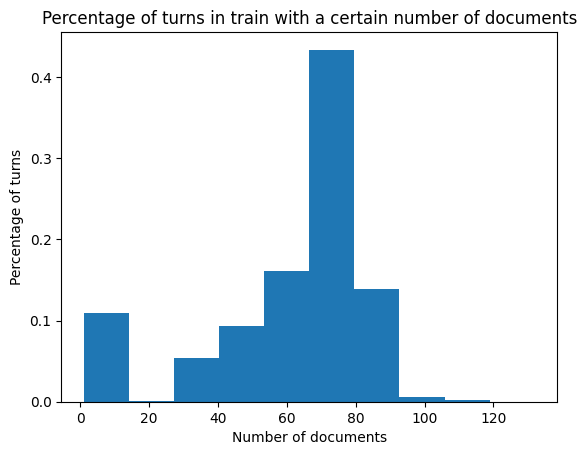

Average number of documents per turn: 61.42017129746417
Standard deviation of number of documents per turn: 22.398556456690674
Maximum number of documents per turn: 132


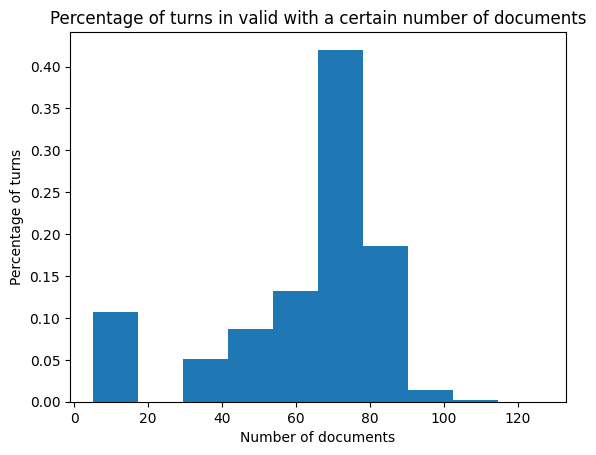

Average number of documents per turn: 62.541941350306885
Standard deviation of number of documents per turn: 22.380606983552344
Maximum number of documents per turn: 127


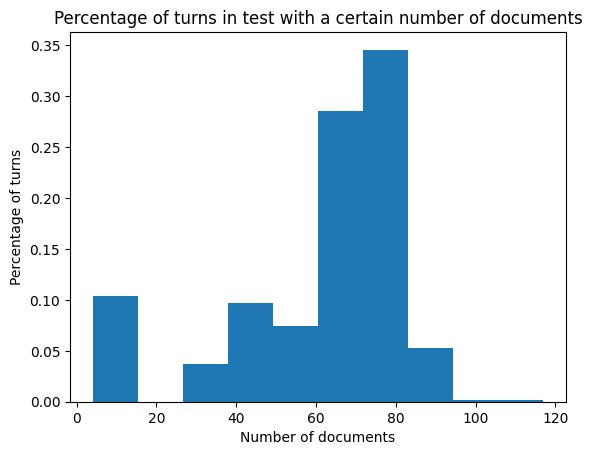

Average number of documents per turn: 61.015296803652966
Standard deviation of number of documents per turn: 21.996419255681708
Maximum number of documents per turn: 117


In [19]:
import matplotlib.pyplot as plt
import numpy as np

for split in ["train", "valid", "test"]:
    n_documents = []
    for dialogue in splits[split].values():
        if dialogue["speaker"] == "wizard":
            documents = set(dialogue["chosen_topic_passage"])
            documents.update([sent for topic in dialogue["self_passages"].values() for sent in topic])
            documents.update([sent for topic in dialogue["partner_passages"].values() for sent in topic])
            n_documents.append(len(documents))

    plt.hist(n_documents, weights=[1/len(n_documents)]*len(n_documents))
    plt.xlabel("Number of documents")
    plt.ylabel("Percentage of turns")
    plt.title(f"Percentage of turns in {split} with a certain number of documents")
    plt.show()

    print(f"Average number of documents per turn: {np.mean(n_documents)}")
    print(f"Standard deviation of number of documents per turn: {np.std(n_documents)}")
    print(f"Maximum number of documents per turn: {max(n_documents)}")

## Retriever Stats

### Sentence level

In [7]:
import json
from tqdm import tqdm

for split in ["train", "valid", "test"]:
    with open(f"../data/WizardOfWikipedia/{split}.json", "r") as f:
        data = json.load(f)
    top_k_accuracy = {1: 0, 3: 0, 5: 0}
    valid_sentences = 0
    for sample_id, sample in tqdm(data.items(), desc=f"Analysing {split} samples"):

        gold_sentence = sample["gold_sentence"]["sentence"]
        if gold_sentence is None:
            continue
        valid_sentences += 1
        retrieved_sentences = [summary["sentence"] for summary in sample["retrieved_sentences"]]
        for i in [1, 3, 5]:
            if gold_sentence in retrieved_sentences[:i]:
                top_k_accuracy[i] += 1
    for i in [1, 3, 5]:
        top_k_accuracy[i] /= valid_sentences
        print(f"\tRecall@{i} for {split}: {top_k_accuracy[i]*100}")
    
    

Analysing train samples: 100%|██████████| 83247/83247 [00:00<00:00, 368511.17it/s]


	Recall@1 for train: 12.22686582565849
	Recall@3 for train: 31.541676340840493
	Recall@5 for train: 46.08518432525862


Analysing valid samples: 100%|██████████| 4399/4399 [00:00<00:00, 490854.86it/s]


	Recall@1 for valid: 13.891577928363988
	Recall@3 for valid: 31.243949661181027
	Recall@5 for valid: 43.780251694094865


Analysing test samples: 100%|██████████| 4380/4380 [00:00<00:00, 406700.13it/s]

	Recall@1 for test: 12.218181818181819
	Recall@3 for test: 33.381818181818176
	Recall@5 for test: 47.1030303030303


### Topic level

In [35]:
import json
from tqdm import tqdm

for split in ["train", "valid", "test"]:
    with open(f"../data/WizardOfWikipedia/{split}.json", "r") as f:
        data = json.load(f)
    top_k_accuracy = {1: 0, 3: 0, 5: 0}
    valid_sentences = 0
    for sample_id, sample in tqdm(data.items(), desc=f"Analysing {split} samples"):

        gold_sentence = sample["gold_sentence"]["topic"]
        if gold_sentence is None:
            continue
        valid_sentences += 1
        retrieved_sentences = [summary["topic"] for summary in sample["retrieved_sentences"]]
        for i in [1, 3, 5]:
            if gold_sentence in retrieved_sentences[:i]:
                top_k_accuracy[i] += 1
    for i in [1, 3, 5]:
        top_k_accuracy[i] /= valid_sentences
        print(f"\tRecall@{i} for {split}: {top_k_accuracy[i]*100}")
    
    

Analysing train samples: 100%|██████████| 83247/83247 [00:00<00:00, 433835.29it/s]


	Recall@1 for train: 66.89884683848
	Recall@3 for train: 75.93194541186182
	Recall@5 for train: 79.6713360678998


Analysing valid samples: 100%|██████████| 4399/4399 [00:00<00:00, 217679.63it/s]


	Recall@1 for valid: 62.89932236205228
	Recall@3 for valid: 73.37850919651501
	Recall@5 for valid: 78.00096805421104


Analysing test samples: 100%|██████████| 4380/4380 [00:00<00:00, 479737.07it/s]

	Recall@1 for test: 68.67878787878789
	Recall@3 for test: 79.22424242424242
	Recall@5 for test: 82.73939393939393


## Generation stats

In [1]:
from utils import collect_task_replies

task_replies = collect_task_replies("../output/WizardOfWikipedia/")

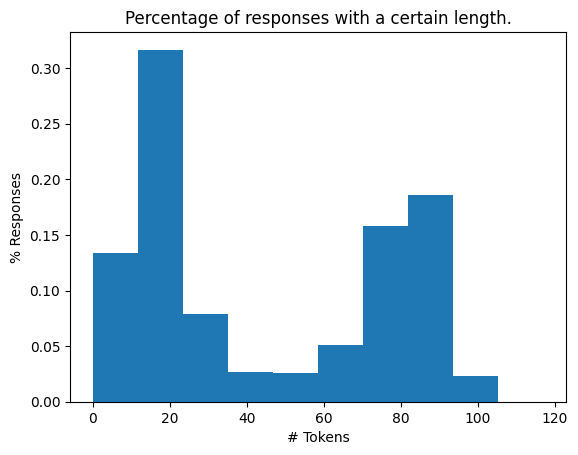

# candidates 70080


In [2]:
import matplotlib.pyplot as plt

lengths = []
for sample_id, sample in task_replies.items():
    for c_name, candidate in sample.items():
        if c_name == "gt":
            continue
        lengths.append(len(candidate.split()))

y, bins, fig = plt.hist(lengths, 10, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("# Tokens")
plt.ylabel("% Responses")
plt.title("Percentage of responses with a certain length.")
plt.show()
print(f"# candidates {len(lengths)}")


In [6]:
len_threshold = 80
lengths_lower_than_threshold = [l for l in lengths if l <= len_threshold]
print(f"Percentage of responses with length lower than {len_threshold}: {round(len(lengths_lower_than_threshold)/len(lengths)*100, 2)}%")

Percentage of responses with length lower than 80: 77.12%


## Sample dialogues for human evaluation

#### Random Sampling

In [1]:
import json

from tqdm import tqdm

from utils import collect_task_replies, fix_replies_if_necessary

task_replies = collect_task_replies("../output/WizardOfWikipedia/")

with open("../data/WizardOfWikipedia/test.json", "r") as f:
    data = json.load(f)

possible_samples = 0
valid_samples = {
    "with_knowledge": {},
    "without_knowledge": {}
}
for sample_id, sample in tqdm(data.items(), desc="Processing samples"):
    dialogue_id = sample["dialogue_id"]
    turn_id = sample["turn_id"]
    history = sample["dialogue_history"][1:] # remove the topic

    if turn_id not in [5, 6]:
        continue
    possible_samples += 1

    has_knowledge = sample["gold_sentence"]["sentence"] is not None

    if has_knowledge:
        key = "with_knowledge"
    else:
        key = "without_knowledge"

    replies = {model: reply.lower() for model, reply in task_replies[sample_id].items()}

    try:
        candidates = fix_replies_if_necessary(replies, max_tokens=35, max_sentences=4, max_candidate_length=80)
    except:
        continue

    identical_candidates = {}
    for c_name, c in candidates.items():
        remaining_candidates = [value for key, value in candidates.items() if key != c_name]
        if c in remaining_candidates:
            if c not in identical_candidates:
                identical_candidates[c] = []
            identical_candidates[c].append(c_name)

    new_candidates = {}
    for c_name, c in candidates.items():
        if c not in identical_candidates:
            new_candidates[c_name] = c
    
    for c in identical_candidates:
        if "gt" in identical_candidates[c]:
            c_name = "gt"
        else:
            c_name = identical_candidates[c][0]
        new_candidates[c_name] = c

    if dialogue_id not in valid_samples[key]:
        valid_samples[key][dialogue_id] = {}

    valid_samples[key][dialogue_id][sample_id] = {
        "sample_id": sample_id,
        "dialogue_id": dialogue_id,
        "turn_id": turn_id,
        "history": [turn.lower() for turn in history],
        "candidates": new_candidates,
        "has_knowledge": has_knowledge, 
        "idenitical_candidates": identical_candidates,
    }

print("Number of samples:", len(data))
print("Number of samples at turn 5 and 6:", possible_samples)
print("Number of valid samples:", len(set(list(valid_samples["with_knowledge"].keys()) + list(valid_samples["without_knowledge"].keys()))))

Processing samples: 100%|██████████| 4380/4380 [00:00<00:00, 4681.69it/s]

Number of samples: 4380
Number of samples at turn 5 and 6: 968
Number of valid samples: 870


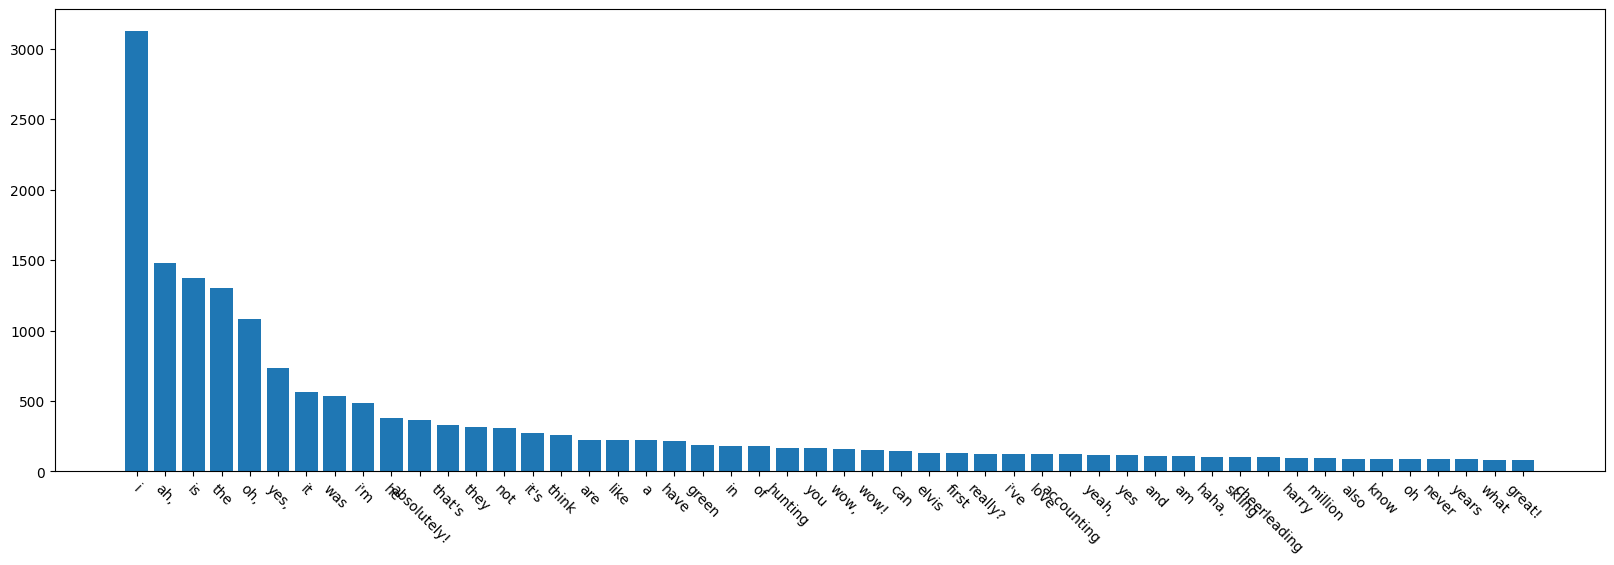

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

tokens = Counter()
for categories in valid_samples.values():
    for samples_per_dialogue in categories.values():
        for sample in samples_per_dialogue.values():
            for candidate in sample["candidates"].values():
                tokens.update([w.lower() for w in candidate.split()[:2]])


most_common = tokens.most_common(200)

plt.figure(figsize=(20, 6))
plt.bar([k[0] for k in most_common[:50]], [k[1] for k in most_common[:50]])
plt.xticks(rotation=-45)
plt.show()



In [3]:
print("Number of valid samples with knowledge:", len(valid_samples["with_knowledge"]))
print("Number of valid samples without knowledge:", len(valid_samples["without_knowledge"]))

Number of valid samples with knowledge: 828
Number of valid samples without knowledge: 42


In [4]:
import os
import random
from statistics import mean

from utils import get_candidates_per_batch

random.seed(7)

n_dial_to_sample = 10
samples_to_eval = {}
dialogue_blacklist = set()

blacklist = [
    270,
    669
]

max_history_tokens = 0
max_history_chars = 0
dialogue_keys = list(valid_samples["without_knowledge"])
random.shuffle(dialogue_keys)
for dialogue_id in blacklist:
    if dialogue_id in dialogue_keys:
        dialogue_keys.remove(dialogue_id)

for dialogue_id in dialogue_keys[:n_dial_to_sample]:
    dialogue_blacklist.add(dialogue_id)
    sample_id = random.sample(list(valid_samples["without_knowledge"][dialogue_id].keys()), 1).pop()
    samples_to_eval[sample_id] = valid_samples["without_knowledge"][dialogue_id][sample_id]
    sample = samples_to_eval[sample_id]

    max_history_tokens = max(max_history_tokens, sum([len(turn.split()) for turn in sample["history"]]))
    max_history_chars = max(max_history_chars, sum([len(turn) for turn in sample["history"]]))

assert len(dialogue_blacklist) == n_dial_to_sample, dialogue_blacklist
n_samples_without_knowledge = len(samples_to_eval)
print("Number of sampled dialogues without knowledge:", len(samples_to_eval))


dialogue_keys = [dialogue_id for dialogue_id in valid_samples["with_knowledge"] if dialogue_id not in dialogue_blacklist]
random.shuffle(dialogue_keys)
for dialogue_id in blacklist:
    if dialogue_id in dialogue_keys:
        dialogue_keys.remove(dialogue_id)

for dialogue_id in dialogue_keys[:n_dial_to_sample]:
    dialogue_blacklist.add(dialogue_id)
    sample_id = random.sample(list(valid_samples["with_knowledge"][dialogue_id].keys()), 1).pop()
    samples_to_eval[sample_id] = valid_samples["with_knowledge"][dialogue_id][sample_id]
    sample = samples_to_eval[sample_id]

    max_history_tokens = max(max_history_tokens, sum([len(turn.split()) for turn in sample["history"]]))
    max_history_chars = max(max_history_chars, sum([len(turn) for turn in sample["history"]]))

assert len(dialogue_blacklist) == n_dial_to_sample*2, dialogue_blacklist
print("Number of sampled dialogues with knowledge:", len(samples_to_eval) - n_samples_without_knowledge)

print("Max Token in History:", max_history_tokens)
print("Max Characters in History:", max_history_chars)

with open("../data/WizardOfWikipedia/samples_to_eval.json", "w") as f:
    json.dump(samples_to_eval, f, indent=4)

for sample in task_replies.values():
    model_candidates = list(sample.keys())
    break

print("Number of candidates:", len(model_candidates))

candidates_per_batch = get_candidates_per_batch(model_candidates, 4)

for batch_id, candidates in enumerate(candidates_per_batch):
    samples_per_batch_to_eval = {}
    actual_candidates = []
    for sample_id, sample in samples_to_eval.items():
        samples_per_batch_to_eval[sample_id] = {
            "sample_id": sample_id,
            "dialogue_id": sample["dialogue_id"],
            "turn_id": sample["turn_id"],
            "history": sample["history"],
            "candidates": {model: sample["candidates"][model] for model in candidates if model in sample["candidates"]},
            "has_knowledge": sample["has_knowledge"],
        }
        # add the ground truth
        samples_per_batch_to_eval[sample_id]["candidates"]["gt"] = sample["candidates"]["gt"]
        actual_candidates.append(len(samples_per_batch_to_eval[sample_id]["candidates"]))
    print(f"Number of samples in batch {batch_id}:", len(samples_per_batch_to_eval))
    print(f"\tAvg Number of candidates in batch {batch_id}:", mean(actual_candidates))
    print(f"\tMin number of candidates in batch {batch_id}:", min(actual_candidates))
    print(f"\tMax number of candidates in batch {batch_id}:", max(actual_candidates))

    out_folder = f"../data/WizardOfWikipedia/human_eval/batch_{batch_id}"
    os.makedirs(out_folder, exist_ok=True)
    with open(f"{out_folder}/samples_to_eval.json", "w") as f:
        json.dump(samples_per_batch_to_eval, f, indent=4)

Number of sampled dialogues without knowledge: 10
Number of sampled dialogues with knowledge: 10
Max Token in History: 156
Max Characters in History: 868
Number of candidates: 17
Number of samples in batch 0: 20
	Avg Number of candidates in batch 0: 5
	Min number of candidates in batch 0: 5
	Max number of candidates in batch 0: 5
Number of samples in batch 1: 20
	Avg Number of candidates in batch 1: 4.8
	Min number of candidates in batch 1: 4
	Max number of candidates in batch 1: 5
Number of samples in batch 2: 20
	Avg Number of candidates in batch 2: 5
	Min number of candidates in batch 2: 5
	Max number of candidates in batch 2: 5
Number of samples in batch 3: 20
	Avg Number of candidates in batch 3: 4.8
	Min number of candidates in batch 3: 4
	Max number of candidates in batch 3: 5


## Sample dialogues for generation

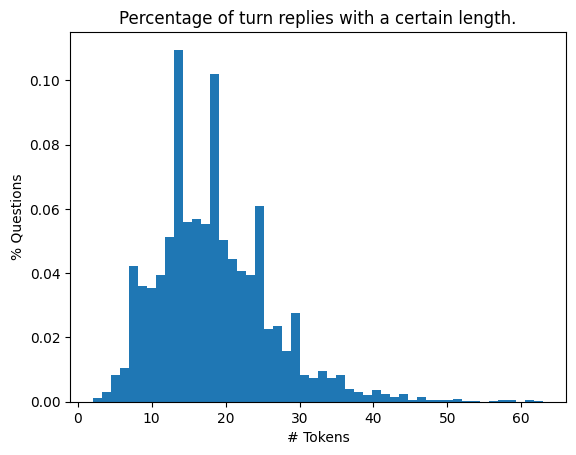

Number of turns 4399


In [7]:
import matplotlib.pyplot as plt

# Calculate the length per turn
lengths = []
for sample in splits["valid"].values():
    if sample["speaker"] == "wizard":
        lengths.append(len(sample["text"].split()))

# Create the bar plot
y, bins, fig = plt.hist(lengths, 50, weights=[1/len(lengths)]*len(lengths))
plt.xlabel("# Tokens")
plt.ylabel("% Questions")
plt.title("Percentage of turn replies with a certain length.")
plt.show()
print(f"Number of turns {len(lengths)}")


In [8]:
from tqdm import tqdm
import random

def prepare_split(samples, bins, split_size):

    random.seed(42)
    dataset = {}
    for sample_id, sample in tqdm(samples.items(), desc=f"Preparing Stratified split"):
        for i, bin in enumerate(bins[1:]):
            if sample["speaker"] == "wizard":
                if len(sample["text"].split()) <= bin:
                    if i not in dataset:
                        dataset[i] = []
                    dataset[i].append({
                        "sample_id": sample_id,
                        "text": sample["text"],
                    })
                    break
    splits = []
    for i, split in dataset.items():
        try:
            splits += random.sample(split, int(len(split) * split_size))
        except ValueError:
            continue

    return splits

In [9]:
splits = prepare_split(splits["valid"], bins, 0.1)
len(splits)

Preparing Stratified split: 100%|██████████| 8806/8806 [00:00<00:00, 115718.53it/s]


420

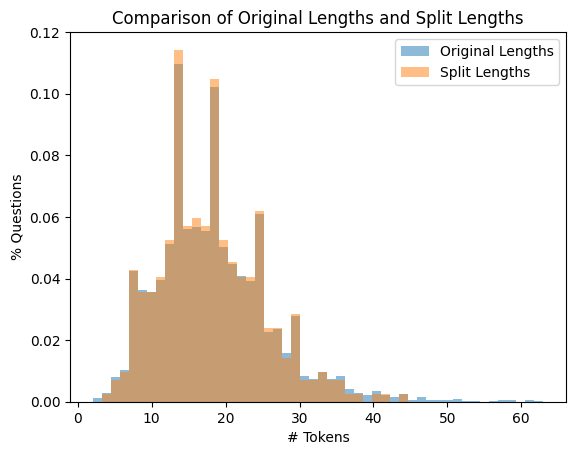

In [10]:
plt.hist(lengths, bins, weights=[1/len(lengths)]*len(lengths), alpha=0.5, label='Original Lengths')
plt.hist([len(sample["text"].split()) for sample in splits], bins, weights=[1/len(splits)]*len(splits), alpha=0.5, label='Split Lengths')
plt.xlabel("# Tokens")
plt.ylabel("% Questions")
plt.title("Comparison of Original Lengths and Split Lengths")
plt.legend()
plt.show()


In [17]:
import json
from copy import deepcopy

with open("../data/WizardOfWikipedia/valid.json", "r") as f:
    valid = json.load(f)

dataset = {}
for sample in splits:
    dataset[f'{sample["sample_id"]}'] = sample

with open("valid_optimization.json", "w") as f:
    json.dump(splits, f, indent=4)

valid_optimization = deepcopy(valid)
for sample_id, sample in valid.items():
    if sample_id not in dataset:
        del valid_optimization[sample_id]

assert len(valid_optimization) == len(splits)

with open("valid_optimization.json", "w") as f:
    json.dump(valid_optimization, f, indent=4)

In [12]:
from transformers import AutoTokenizer

llama = "meta-llama/Llama-2-7b-chat-hf"
mistral = "mistralai/Mistral-7B-Instruct-v0.1"

/home/simone/miniconda3/envs/inlg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from tqdm import tqdm
import statistics
import json

tokenizer = AutoTokenizer.from_pretrained(llama)

with open("../data/WizardOfWikipedia/valid.json", "r") as f:
    valid = json.load(f)

lengths = []
for sample in tqdm(valid.values()):
    sample["input_ids"] = tokenizer(sample["text"])
    lengths.append(len(sample["input_ids"]["input_ids"]))

max_length = max(lengths)
mean_length = statistics.mean(lengths)

print("Maximum Length:", max_length)
print("Mean Length:", mean_length)


100%|██████████| 4399/4399 [00:00<00:00, 15110.74it/s]

Maximum Length: 92
Mean Length: 27.06365082973403


In [32]:
import statistics

with open("../data/WizardOfWikipedia/train.json", "r") as f:
    valid = json.load(f)

context_length = []
for sample in valid.values():
    length = 0
    for s in sample["retrieved_sentences"][:3]:
        # skip sentences which are too long
        #if len(s["sentence"].split()) > 512:
        #    continue
        length += len(tokenizer.encode(s["sentence"]))
    context_length.append(length)

print("Mean Context Length:", statistics.mean(context_length))
print("Max Context Length:", max(context_length))

Mean Context Length: 103.41397287589943
Max Context Length: 4850


## Error Analysis

In [ ]:
!pip install parlai

In [5]:

import json
from pathlib import Path

from parlai.core.metrics import TeacherMetrics
from tqdm import tqdm

with open("../data/WizardOfWikipedia/test.json", "r") as f:
    data = json.load(f)

task_replies = {}
for model in Path("../output/WizardOfWikipedia").iterdir():
    if model.is_dir():
        for elem in model.iterdir():
            if elem.is_file():
                if elem.name.startswith("generation_results_"):
                    with open(elem, "r") as f:
                        replies = json.load(f)["results"]
                    for sample_id, reply in replies.items():
                        if sample_id not in task_replies:
                            task_replies[sample_id] = {
                                "gt": reply["target"],
                            }
                        task_replies[sample_id][
                            f'{model.name}_prompt_{elem.name.split("generation_results_")[-1]}'
                        ] = reply["output"]
            elif elem.is_dir():
                for file in elem.iterdir():
                    if file.is_file():
                        if file.name.startswith("generation_results_"):
                            with open(file, "r") as f:
                                replies = json.load(f)["results"]
                            for sample_id, reply in replies.items():
                                if sample_id not in task_replies:
                                    task_replies[sample_id] = {
                                        "gt": reply["target"],
                                    }
                                task_replies[sample_id][
                                    f'{model.name}_ft_{file.name.split("generation_results_")[-1]}'
                                ] = reply["output"]

### BLEU

In [16]:
from utils import collect_task_replies

task_replies = collect_task_replies("../output/WizardOfWikipedia")

task_replies = {sample_id: {c_name: candidate.lower() for c_name, candidate in sample.items()} for sample_id, sample in task_replies.items() if sample_id.split("_")[-1] in ["5", "6"]}

print("Number of samples:", len(task_replies))

replacements = {
    "_": " ",
    ".json": "",
    "mistral": "Mistral",
    "llama": "Llama2",
    "gt": "Ground Truth",
    "none": "",
    "retrieved": "",
    "top-1": "Top 1",
    "top-3": "Top 3",
    "gold": "Gold",
    "prompt": "Prompt",
    "ft": "Fine-Tuned",
    "  ": " ",
}

Number of samples: 968


#### Average

In [18]:
from utils import plot_cross_bleu

candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'])

Computing cross BLEU:   0%|          | 0/968 [00:00<?, ?it/s]

Computing cross BLEU: 100%|██████████| 968/968 [00:24<00:00, 40.17it/s]


In [20]:
candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'])

Computing cross BLEU:   0%|          | 0/968 [00:00<?, ?it/s]

Computing cross BLEU: 100%|██████████| 968/968 [00:20<00:00, 46.59it/s]


#### Max

In [21]:
from utils import plot_cross_bleu

candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'], operation="max")

Computing cross BLEU: 100%|██████████| 968/968 [00:24<00:00, 40.19it/s]


In [22]:
candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

plot_cross_bleu(task_replies, candidates, replacements, results_to_plot=['b4_tok'], operation="max")

Computing cross BLEU:   0%|          | 0/968 [00:00<?, ?it/s]/home/simone/miniconda3/envs/inlg/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning:


The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()

/home/simone/miniconda3/envs/inlg/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning:


The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()

/home/simone/miniconda3/envs/inlg/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning:


The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order 

#### Samples above a threshold

In [6]:
from utils import get_samples_above_threshold


candidates = [
    "gt",
    "llama_ft_none.json",
    "llama_ft_retrieved_top-1.json",
    "llama_ft_retrieved_top-3.json",
    "llama_ft_gold.json",
    "llama_prompt_none.json",
    "llama_prompt_retrieved_top-1.json",
    "llama_prompt_retrieved_top-3.json",
    "llama_prompt_gold.json",
]

llama_samples_above_threshold = get_samples_above_threshold(task_replies, candidates, threshold=1)

print(f"Number of samples above threshold: {round(len(llama_samples_above_threshold)/len(task_replies)*100, 2)}%")

  0%|          | 0/4380 [00:00<?, ?it/s]/home/simone/miniconda3/envs/inlg/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/simone/miniconda3/envs/inlg/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/simone/miniconda3/envs/inlg/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overla

Number of samples above threshold: 13.58%


In [7]:
from utils import get_samples_above_threshold


candidates = [
    "gt",
    "mistral_ft_none.json",
    "mistral_ft_retrieved_top-1.json",
    "mistral_ft_retrieved_top-3.json",
    "mistral_ft_gold.json",
    "mistral_prompt_none.json",
    "mistral_prompt_retrieved_top-1.json",
    "mistral_prompt_retrieved_top-3.json",
    "mistral_prompt_gold.json",
]

mistral_samples_above_threshold = get_samples_above_threshold(task_replies, candidates, threshold=1)

print(f"Number of samples above threshold: {round(len(mistral_samples_above_threshold)/len(task_replies)*100, 2)}%")

100%|██████████| 4380/4380 [00:45<00:00, 96.98it/s] 

Number of samples above threshold: 16.37%


In [8]:
total_samples_above_threshold = llama_samples_above_threshold.union(mistral_samples_above_threshold)
print(f"Total number of samples above threshold: {round(len(total_samples_above_threshold)/len(task_replies)*100, 2)}%")

Total number of samples above threshold: 25.68%


### F1 Unigram-Overlap

#### Full test set

In [ ]:
techniques = {}
for sample_id, sample in tqdm(data.items(), desc="Computing F1"):
    reference = sample["text"]
    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [reference])


for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing F1: 100%|██████████| 4380/4380 [00:19<00:00, 228.31it/s]

llama_prompt_gold.json: 0.1659
llama_ft_gold.json: 0.3841
llama_ft_noisy.json: 0.1639
llama_ft_retrieved_top-3.json: 0.207
llama_prompt_retrieved_top-3.json: 0.1291
llama_ft_none.json: 0.1846
llama_prompt_none.json: 0.1268
llama_ft_retrieved_top-1.json: 0.1967
llama_prompt_retrieved_top-1.json: 0.1261
mistral_prompt_gold.json: 0.1588
mistral_ft_gold.json: 0.3821
mistral_ft_noisy.json: 0.1761
mistral_ft_retrieved_top-3.json: 0.2049
mistral_prompt_retrieved_top-3.json: 0.1222
mistral_ft_none.json: 0.1863
mistral_prompt_none.json: 0.1104
mistral_ft_retrieved_top-1.json: 0.1983
mistral_prompt_retrieved_top-1.json: 0.1116


#### Knowledge-access Turns

In [ ]:
techniques = {}
for sample_id, sample in tqdm(data.items(), desc="Computing F1"):
    sentence = sample["gold_sentence"]["sentence"]
    if sentence is None:
        continue

    reference = sample["text"]
    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [reference])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing F1: 100%|██████████| 4380/4380 [00:18<00:00, 232.18it/s]

llama_prompt_gold.json: 0.1688
llama_ft_gold.json: 0.3969
llama_ft_noisy.json: 0.1632
llama_ft_retrieved_top-3.json: 0.2084
llama_prompt_retrieved_top-3.json: 0.1299
llama_ft_none.json: 0.1867
llama_prompt_none.json: 0.1273
llama_ft_retrieved_top-1.json: 0.1975
llama_prompt_retrieved_top-1.json: 0.1266
mistral_prompt_gold.json: 0.1622
mistral_ft_gold.json: 0.3949
mistral_ft_noisy.json: 0.1766
mistral_ft_retrieved_top-3.json: 0.2063
mistral_prompt_retrieved_top-3.json: 0.1231
mistral_ft_none.json: 0.1872
mistral_prompt_none.json: 0.1111
mistral_ft_retrieved_top-1.json: 0.1993
mistral_prompt_retrieved_top-1.json: 0.1126


#### No Knowledge-access Turns

In [8]:
techniques = {}
for sample_id, sample in tqdm(data.items(), desc="Computing F1"):
    sentence = sample["gold_sentence"]["sentence"]
    if sentence is not None:
        continue

    reference = sample["text"]
    for key, value in task_replies[sample_id].items():
        if key in "gt":
            continue
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [reference])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing F1: 100%|██████████| 4380/4380 [00:01<00:00, 4329.35it/s]

llama_prompt_gold.json: 0.1202
llama_ft_gold.json: 0.177
llama_ft_noisy.json: 0.1751
llama_ft_retrieved_top-3.json: 0.184
llama_prompt_retrieved_top-3.json: 0.1168
llama_ft_none.json: 0.1514
llama_prompt_none.json: 0.1184
llama_ft_retrieved_top-1.json: 0.1839
llama_prompt_retrieved_top-1.json: 0.1174
mistral_prompt_gold.json: 0.1041
mistral_ft_gold.json: 0.1753
mistral_ft_noisy.json: 0.1675
mistral_ft_retrieved_top-3.json: 0.1826
mistral_prompt_retrieved_top-3.json: 0.1072
mistral_ft_none.json: 0.1721
mistral_prompt_none.json: 0.1004
mistral_ft_retrieved_top-1.json: 0.1824
mistral_prompt_retrieved_top-1.json: 0.09596


#### Samples with correctly retrieved documents

##### Top-1

In [73]:
techniques = {}
for sample_id, sample in tqdm(data.items(), desc="Computing F1"):
    sentence = sample["gold_sentence"]["sentence"]
    if sentence is None:
        continue
    retrieved_sentences = [summary["sentence"] for summary in sample["retrieved_sentences"][:1]]

    if sentence not in retrieved_sentences:
        continue

    reference = sample["text"]
    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if "retrieved_top-1" in key or "gold" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [reference])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing F1:   0%|          | 0/4380 [00:00<?, ?it/s]

Computing F1: 100%|██████████| 4380/4380 [00:01<00:00, 4317.77it/s]

llama_prompt_gold.json: 0.1528
llama_ft_gold.json: 0.3792
llama_ft_retrieved_top-1.json: 0.304
llama_prompt_retrieved_top-1.json: 0.1522
mistral_prompt_gold.json: 0.1573
mistral_ft_gold.json: 0.3809
mistral_ft_retrieved_top-1.json: 0.3144
mistral_prompt_retrieved_top-1.json: 0.1566


##### Top-3

In [64]:
techniques = {}
for sample_id, sample in tqdm(data.items(), desc="Computing F1"):
    sentence = sample["gold_sentence"]["sentence"]
    if sentence is None:
        continue
    retrieved_sentences = [summary["sentence"] for summary in sample["retrieved_sentences"][:3]]

    if sentence not in retrieved_sentences:
        continue

    reference = sample["text"]
    for key, value in task_replies[sample_id].items():
        if key == "gt":
            continue
        if "retrieved_top-3" in key or "gold" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [reference])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing F1:   0%|          | 0/4380 [00:00<?, ?it/s]

Computing F1: 100%|██████████| 4380/4380 [00:02<00:00, 1616.99it/s]

llama_prompt_gold.json: 0.1561
llama_ft_gold.json: 0.3955
llama_ft_retrieved_top-3.json: 0.2966
llama_prompt_retrieved_top-3.json: 0.1472
mistral_prompt_gold.json: 0.1593
mistral_ft_gold.json: 0.3949
mistral_ft_retrieved_top-3.json: 0.2921
mistral_prompt_retrieved_top-3.json: 0.1633


### KF1 Unigram-Overlap (w. knowledge)

#### Full test set

In [9]:
techniques = {}
for sample_id, sample in tqdm(data.items(), desc="Computing KF1"):
    reference = sample["gold_sentence"]["sentence"]
    if reference is None:
        continue
    for key, value in task_replies[sample_id].items():
        if key not in techniques:
            techniques[key] = TeacherMetrics()
        techniques[key].evaluate_response({"text": value}, [reference])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1: 100%|██████████| 4380/4380 [00:19<00:00, 224.96it/s]

gt: 0.3848
llama_prompt_gold.json: 0.2103
llama_ft_gold.json: 0.7623
llama_ft_noisy.json: 0.2169
llama_ft_retrieved_top-3.json: 0.251
llama_prompt_retrieved_top-3.json: 0.1351
llama_ft_none.json: 0.1743
llama_prompt_none.json: 0.1162
llama_ft_retrieved_top-1.json: 0.2029
llama_prompt_retrieved_top-1.json: 0.125
mistral_prompt_gold.json: 0.2595
mistral_ft_gold.json: 0.6836
mistral_ft_noisy.json: 0.2038
mistral_ft_retrieved_top-3.json: 0.2163
mistral_prompt_retrieved_top-3.json: 0.1776
mistral_ft_none.json: 0.1547
mistral_prompt_none.json: 0.1096
mistral_ft_retrieved_top-1.json: 0.1872
mistral_prompt_retrieved_top-1.json: 0.1383


#### Samples with correctly retrieved documents

##### Top-1

In [11]:
techniques = {}
for sample_id, sample in tqdm(data.items(), desc="Computing KF1"):
    reference = sample["gold_sentence"]["sentence"]
    if reference is None:
        continue

    retrieved_sentences = [summary["sentence"] for summary in sample["retrieved_sentences"][:1]]

    if reference not in retrieved_sentences:
        continue

    for key, value in task_replies[sample_id].items():
        if "retrieved_top-1" in key or "gold" in key or "gt" in key or "noisy" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [reference])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1: 100%|██████████| 4380/4380 [00:01<00:00, 3162.84it/s]

gt: 0.374
llama_prompt_gold.json: 0.1874
llama_ft_gold.json: 0.8539
llama_ft_noisy.json: 0.8563
llama_ft_retrieved_top-1.json: 0.4904
llama_prompt_retrieved_top-1.json: 0.1878
mistral_prompt_gold.json: 0.2658
mistral_ft_gold.json: 0.7709
mistral_ft_noisy.json: 0.7702
mistral_ft_retrieved_top-1.json: 0.4629
mistral_prompt_retrieved_top-1.json: 0.2528


##### Top-3

In [72]:
techniques = {}
for sample_id, sample in tqdm(data.items(), desc="Computing KF1"):
    reference = sample["gold_sentence"]["sentence"]
    if reference is None:
        continue

    retrieved_sentences = [summary["sentence"] for summary in sample["retrieved_sentences"][:3]]

    if reference not in retrieved_sentences:
        continue

    for key, value in task_replies[sample_id].items():
        if "retrieved_top-3" in key or "gold" in key or "gt" in key:
            if key not in techniques:
                techniques[key] = TeacherMetrics()
            techniques[key].evaluate_response({"text": value}, [reference])

for technique, metrics in techniques.items():
    print(f"{technique}: {metrics.report()['f1']}")

Computing KF1:   0%|          | 0/4380 [00:00<?, ?it/s]

Computing KF1: 100%|██████████| 4380/4380 [00:03<00:00, 1425.09it/s]

gt: 0.3868
llama_prompt_gold.json: 0.1956
llama_ft_gold.json: 0.8473
llama_ft_retrieved_top-3.json: 0.4887
llama_prompt_retrieved_top-3.json: 0.1784
mistral_prompt_gold.json: 0.2678
mistral_ft_gold.json: 0.7531
mistral_ft_retrieved_top-3.json: 0.4099
mistral_prompt_retrieved_top-3.json: 0.2851
